# Cardiotocograms (CTG) classification

I am currently undertaking the nanodegree in Machine Learning from Udacity and so far I am very happy with it. By the time I am starting this project I have completed the first three projects of the degree. These projects are great as they give you precise instructions on how to structure the code so that it is easily readable and understandable. However the downside is that there is a lot of babysitting. With this project I wanted to test my skills of independently formalize and solve a supervised ML classification problem. Also I wanted to have fun experimenting with all the techniques I learned so far. I found this simple database on UCI website: http://mlr.cs.umass.edu/ml/datasets/Cardiotocography. It has 2126 instances, 21 features + 2 labels and doesn't have missing values. As a plus it comes from real CTG scans (https://en.wikipedia.org/wiki/Cardiotocography) which gives me more motivation to analyze it as my goal is to work in bioengineering and I hope to come across more datasets like this in the near future :-) 

### Features

|Feature| Description|
|---|---|
|LB | Fetal Heart Rate baseline (beats per minute)|
|AC | # of accelerations per second| 
|FM | # of fetal movements per second| 
|UC | # of uterine contractions per second| 
|DL | # of light decelerations per second| 
|DS | # of severe decelerations per second| 
|DP | # of prolongued decelerations per second| 
|ASTV | percentage of time with abnormal short term variability| 
|MSTV | mean value of short term variability| 
|ALTV | percentage of time with abnormal long term variability| 
|MLTV | mean value of long term variability| 
|Width | width of FHR histogram| 
|Min | minimum of FHR histogram| 
|Max | Maximum of FHR histogram| 
|Nmax | # of histogram peaks| 
|Nzeros | # of histogram zeros| 
|Mode | histogram mode| 
|Mean | histogram mean| 
|Median | histogram median| 
|Variance | histogram variance| 
|Tendency | histogram tendency| 
|CLASS | FHR pattern class code 1 to 10 for classes A to SUSP| 
|NSP | fetal state class code (1=Normal; 2=Suspect; 3=Pathologic)|

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import renders as rs
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
from IPython.display import Audio
sound_file = "./sounds/beep.wav"

## Data Exploration

In [3]:
CTG = pd.read_csv("CTG.csv")
fs_labels = CTG['NSP']
mp_labels = CTG['CLASS']
data = CTG.drop(['CLASS', 'NSP'], axis = 1)

In [4]:
data.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


So, first thing that I notice about the data is that the range of values varies a lot among features: for example LB is in the order of 10^2 while AC is in the order of 10^-2. This characteristic may cause those classifiers that rely on the calculation of some form of distance to take decisions on how to split data to perform poorly. Let's take SVMs for example: the goal of the learning algorithm is to find the hyperplane that best separates two classes of data. If value range changes too much among features it is possible that significant variations in a feature with small range are not taken into account by the classifier because obscured by a small change in a wide range one. In this case a variation of 50% in the mean in AC ( = 0.029) will be less valuable to the classifier than a variation of 5% in LB (= 127.35). Other classifiers that have this problem are Kmeans and Neural Networks. An easy solution to this problem is to normalize all the values to the same range: by doing so the information is preserved and now is comparable for each feature.
It is definitely worth to notice that there are classifiers that do not care if the features have different ranges, an example are trees and, as a consiquence, random forests. This class of classifiers (eheh) learn the a binary tree that at each node takes into account one and only one feature (there is a lot of smart engineering in doing this, I will talk about this later) and splits the data according to some metric. Bayesian classifiers are another class that does not care about range as all they want are the prior probabilities of each feature.

Basically this whole problem can be described with this example: imagine of being asked to separate N boxes of fruits (data points) containing one orange, one strawberry and one cherry according to the fruits color from dark to light. You cannot move fruits from one box to the other, but just order the boxes according to the amount of dark or light fruits they contain. One technique to do so is to compare one type of fruit in each box first and order accordingly and then repeat for the others. This is the trees philosophy. It is clear how in this case there is no need to worry on how cherries compare to oranges because we are not actually making that comparison, what we are actually measuring is the change of color in, say, cherries first, then strawberries then oranges. The other approach is to compare the boxes as whole, the SVM's approach. In this case you will be forced to look at things from a wider perspective and most likely those fruits that have a wider range of colors like strawberries will have a greater weight in defining the position of each box than oranges that are all of a similar, well, orange. However a small change in the oranges color should be as significant as a big one in strawberries. Basically normalization ends fruit racism ;-)

In [5]:
def class_frequency(array):
    """It measures the frequence of each class in the array. """
    val = array.value_counts()
    class_freq = val/len(array)
    idx = class_freq.index
    
    for i, freq in np.ndenumerate(class_freq):
        print "The frequency of class {0} is {1:.3}".format(idx[i], freq)
    
    return class_freq

In [6]:
_ = class_frequency(fs_labels)

The frequency of class 1 is 0.778
The frequency of class 2 is 0.139
The frequency of class 3 is 0.0828


Another thing that I learned is always best practice to do is to check if classes are equally represented in the data. This is extremely important because a skewed dataset will likely teach that by often guessing the predominant class it will be correst the majority of the time. And indeed this is excactly the case of this dataset. As can be seen from the results above Normal cases represents circa the 78% of the data, Suspects ones the 14% and those that are classified as Pathologic only the 8%. This is not surprising given that these data are a sample of a real distribution of health conditions. A disease normally affects only a small part of the population while the majority are healthy.

There are some ways in which we can deal with skewed data and this nice blogpost explains very well the main actions that can be taken: http://florianhartl.com/thoughts-on-machine-learning-dealing-with-skewed-classes.html . As the author says the first thing to consider is the metric choice.

Then how you sample the data. This though can be done only if you hypothesize that data were not collected correctly and they actually come from a distribution with uniformally represented classes which is not my case. I know that it being a generic medical exam I will have a higher representation of healthy oveer pathological ones.

ensembling seems like a super duper good idea. Explain briefly and focus on it later.

Add why you are reducing the classes


In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

rept = 100
for feat in data.columns:
    
    sum_score = 0
    new_data = data.drop(feat, axis=1)
    labels = data[feat]
    
    for i in range(rept):
        X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(new_data, labels)
        regressor = DecisionTreeRegressor()
        
        regressor.fit(X_train_t, y_train_t)
        prd = regressor.predict(X_test_t)
        sum_score += r2_score(y_test_t, prd)
        
    score = sum_score/rept
    print "The R^2 score for %s is %.3f" %(feat, score)

The R^2 score for LB is 0.835
The R^2 score for AC is 0.613
The R^2 score for FM is -0.121
The R^2 score for UC is 0.155
The R^2 score for DL is 0.698
The R^2 score for DS is -0.001
The R^2 score for DP is 0.545
The R^2 score for ASTV is 0.716
The R^2 score for MSTV is 0.719
The R^2 score for ALTV is 0.717
The R^2 score for MLTV is 0.303
The R^2 score for Width is 0.987
The R^2 score for Min is 0.983
The R^2 score for Max is 0.927
The R^2 score for Nmax is 0.370
The R^2 score for Nzeros is -0.174
The R^2 score for Mode is 0.872
The R^2 score for Mean is 0.944
The R^2 score for Median is 0.966
The R^2 score for Variance is 0.739
The R^2 score for Tendency is 0.548


<IPython.core.display.Javascript object>


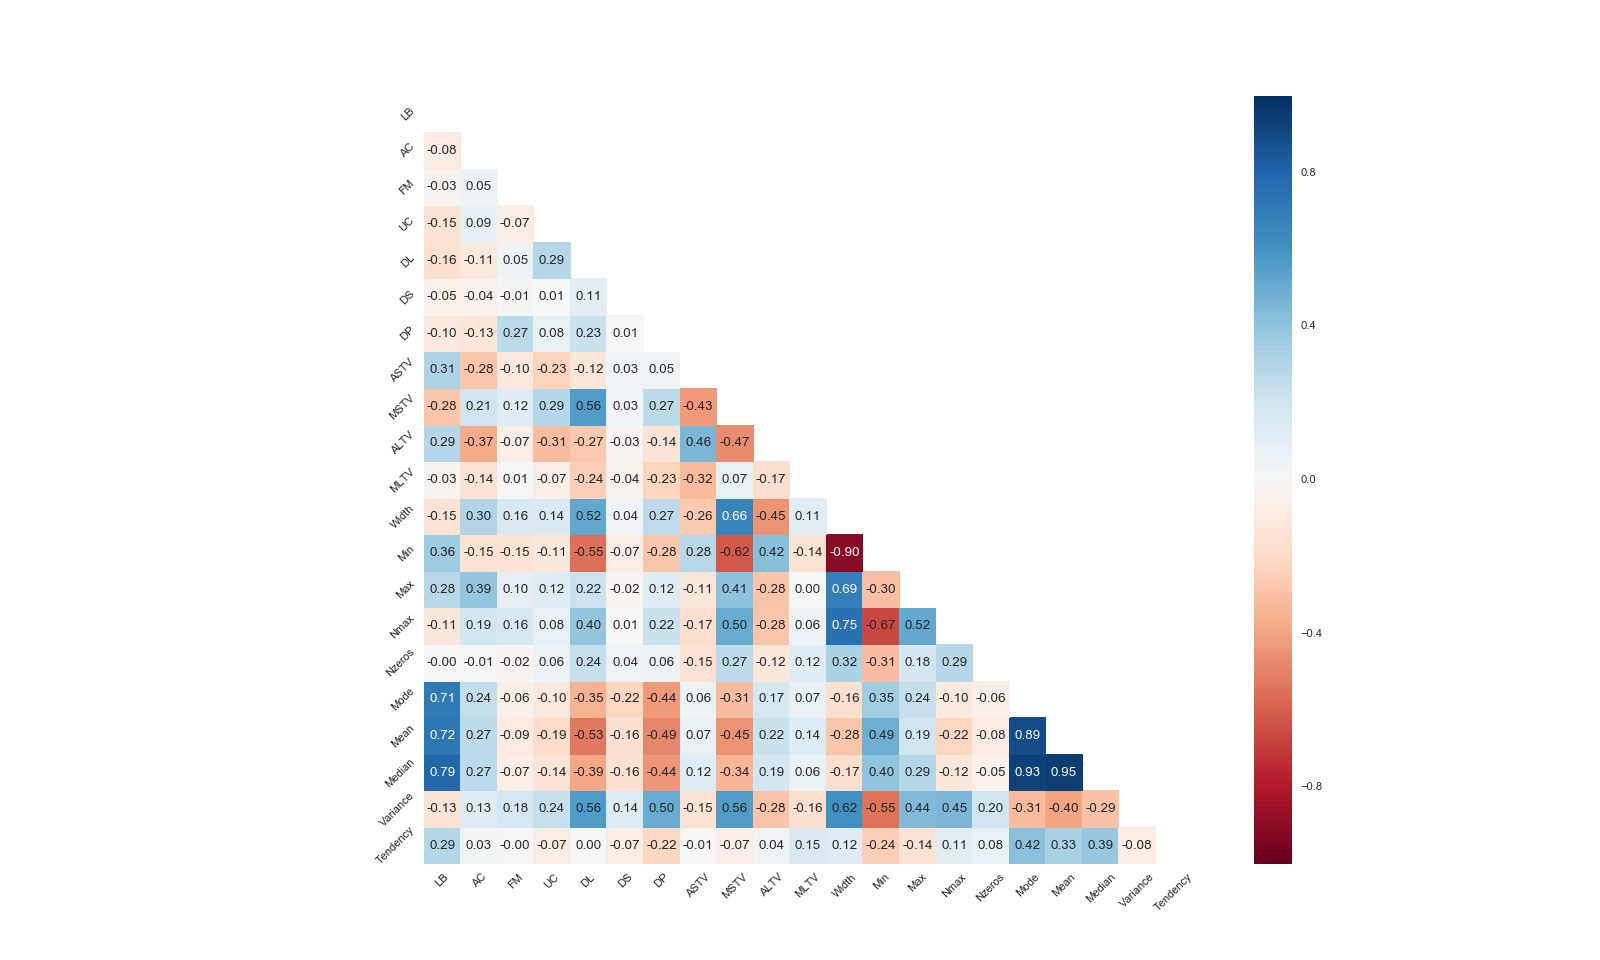

In [8]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(20,12))
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='.2f')
    plt.xticks(rotation=45, ha="center")
    plt.yticks(rotation=45, ha="right")

## Data Preprocessing

I am going to merge class 1 and class 2 for two reasons: 

- class size
- scope of the classifier

Class 2 and 3 represent the minority of elements in the data. The little number of examples makes it difficult for the classifier to effectively identify those classes. By merging them I am going to obtain a larger class that is going to be easier for the classifier to recognize.
The second point is the most important. With this model I want to create a tool for doctors that can help them recognize when a patient is at risk of having a pathological conditions. This means that I want to notify the doctors when an instance belongs to class 2 as well as when it belongs to class 3. It follows that these two classes can be considered as one. I reckon that it would be even more helpful to provide a quantification of the probability that an element belongs to a class rather than another but that feature is not going to be included into this project. 

In [7]:
# the value of the class of normal cases is set to -1, negative (absence of disease)
idxs = fs_labels[fs_labels == 1]
fs_labels[idxs.index] = -1

# suspicious and pathologic exams are merged in one class with positive value (presence or suspect of presence of disease)
idxs = fs_labels[fs_labels == 2]
fs_labels[idxs.index] = +1

idxs = fs_labels[fs_labels == 3]
fs_labels[idxs.index] = +1

C:\Users\Ludovica\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Ludovica\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Ludovica\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Outliers detection

In [8]:
import scipy.stats
from IPython.display import display # Allows the use of display() for DataFrames

all_outliers = []

for feature in data.keys():
    
    # identify outliers using Tukey's method
    Q1 = np.percentile(data[feature], 25, axis=0)
    Q3 = np.percentile(data[feature], 75, axis=0)
    
    step = 1.5 * (Q3-Q1)
    
    print "Data points considered outliers for feature {}".format(feature)
    display(data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))])
    
    # save the outliers list to perform selected removal later of those rows being outliers for more than two class
    outliers = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))].index.tolist()
    
    all_outliers += outliers
    
    # thresholding the outliers to the 5th and the 95th percentile
    for x in outliers:
        scipy.stats.mstats.winsorize(data[feature], limits=0.05)
    

Data points considered outliers for feature LB


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature AC


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
181,138,0.017,0.000,0.005,0.000,0,0,35,5.3,0,...,148,52,200,11,2,146,157,161,72,1
497,130,0.016,0.084,0.002,0.000,0,0,34,2.1,0,...,132,50,182,8,0,159,151,155,25,1
529,142,0.019,0.085,0.000,0.000,0,0,32,2.3,0,...,144,56,200,10,0,170,158,162,37,1
530,142,0.016,0.071,0.000,0.002,0,0,32,3.1,0,...,149,51,200,10,0,167,154,160,55,1
531,142,0.016,0.060,0.004,0.000,0,0,38,1.3,0,...,130,68,198,5,0,180,173,177,14,1
552,136,0.016,0.000,0.004,0.000,0,0,35,4.9,0,...,148,52,200,11,2,146,159,162,74,1
630,134,0.017,0.002,0.004,0.000,0,0,48,2.2,0,...,120,50,170,5,0,160,150,155,28,1
1093,122,0.016,0.000,0.001,0.000,0,0,22,2.2,0,...,52,100,152,1,0,131,133,134,5,0
1094,122,0.018,0.000,0.002,0.000,0,0,22,2.5,0,...,52,100,152,1,0,136,132,134,6,0
1096,123,0.017,0.000,0.002,0.000,0,0,24,2.2,0,...,52,100,152,1,0,136,133,135,5,0


Data points considered outliers for feature FM


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
12,131,0.005,0.072,0.008,0.003,0,0.000,28,1.4,0,...,66,88,154,5,0,135,134,137,7,1
13,131,0.009,0.222,0.006,0.002,0,0.000,28,1.5,0,...,87,71,158,2,0,141,137,141,10,1
14,130,0.006,0.408,0.004,0.005,0,0.001,21,2.3,0,...,107,67,174,7,0,143,125,135,76,0
15,130,0.006,0.380,0.004,0.004,0,0.001,19,2.3,0,...,107,67,174,3,0,134,127,133,43,0
16,130,0.006,0.441,0.005,0.005,0,0.000,24,2.1,0,...,125,53,178,5,0,143,128,138,70,1
17,131,0.002,0.383,0.003,0.005,0,0.002,18,2.4,0,...,107,67,174,5,0,134,125,132,45,0
18,130,0.003,0.451,0.006,0.004,0,0.001,23,1.9,0,...,99,59,158,6,0,133,124,129,36,1
19,130,0.005,0.469,0.005,0.004,0,0.001,29,1.7,0,...,112,65,177,6,1,133,129,133,27,0
20,129,0.000,0.340,0.004,0.002,0,0.003,30,2.1,0,...,128,54,182,13,0,129,104,120,138,0
21,128,0.005,0.425,0.003,0.003,0,0.002,26,1.7,0,...,141,57,198,9,0,129,125,132,34,0


Data points considered outliers for feature UC


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1164,131,0.011,0,0.015,0,0,0,26,1.5,0,...,61,109,170,2,1,155,151,154,11,1


Data points considered outliers for feature DL


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0,0.002,26,5.9,0,...,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0,0.003,29,6.3,0,...,150,50,200,6,3,71,107,106,215,0
28,132,0.000,0.135,0.001,0.008,0,0.001,29,4.4,0,...,141,50,191,7,1,133,119,129,73,0
29,132,0.000,0.099,0.000,0.012,0,0.000,26,6.0,0,...,143,50,193,10,0,133,113,117,89,0
30,132,0.000,0.108,0.002,0.010,0,0.000,26,4.5,0,...,149,50,199,9,0,133,120,126,56,0
31,132,0.000,0.112,0.004,0.014,0,0.000,22,6.9,0,...,149,50,199,10,0,123,112,115,66,0
32,132,0.000,0.089,0.001,0.010,0,0.000,29,2.9,0,...,144,50,194,11,1,133,124,130,35,0
51,156,0.000,0.000,0.012,0.008,0,0.000,43,4.1,0,...,150,50,200,7,1,151,142,152,72,1
52,156,0.000,0.000,0.011,0.008,0,0.001,34,5.4,0,...,150,50,200,8,0,117,131,136,108,0
106,125,0.000,0.050,0.000,0.008,0,0.000,22,3.9,0,...,145,52,197,7,1,121,117,121,23,0


Data points considered outliers for feature DS


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1488,132,0.002,0.000,0.008,0.000,0.001,0.001,31,1.4,0,...,102,61,163,5,0,99,121,129,94,1
1489,132,0.000,0.000,0.006,0.000,0.001,0.001,32,1.3,0,...,91,60,151,1,1,99,116,125,72,1
1791,121,0.000,0.001,0.004,0.010,0.001,0.000,66,2.1,0,...,105,55,160,7,0,67,85,92,109,-1
1792,121,0.000,0.001,0.003,0.011,0.001,0.000,67,2.1,0,...,102,55,157,4,1,67,81,87,89,-1
1793,121,0.000,0.001,0.005,0.012,0.001,0.000,66,2.1,0,...,102,55,157,5,1,67,83,90,98,-1
1794,121,0.000,0.001,0.003,0.010,0.001,0.000,68,2.1,0,...,102,55,157,3,1,67,79,82,83,-1
1795,121,0.000,0.000,0.004,0.009,0.001,0.000,70,1.9,0,...,102,55,157,6,2,67,76,79,68,-1


Data points considered outliers for feature DP


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0,0.002,26,5.9,0,...,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0,0.003,29,6.3,0,...,150,50,200,6,3,71,107,106,215,0
14,130,0.006,0.408,0.004,0.005,0,0.001,21,2.3,0,...,107,67,174,7,0,143,125,135,76,0
15,130,0.006,0.380,0.004,0.004,0,0.001,19,2.3,0,...,107,67,174,3,0,134,127,133,43,0
17,131,0.002,0.383,0.003,0.005,0,0.002,18,2.4,0,...,107,67,174,5,0,134,125,132,45,0
18,130,0.003,0.451,0.006,0.004,0,0.001,23,1.9,0,...,99,59,158,6,0,133,124,129,36,1
19,130,0.005,0.469,0.005,0.004,0,0.001,29,1.7,0,...,112,65,177,6,1,133,129,133,27,0
20,129,0.000,0.340,0.004,0.002,0,0.003,30,2.1,0,...,128,54,182,13,0,129,104,120,138,0
21,128,0.005,0.425,0.003,0.003,0,0.002,26,1.7,0,...,141,57,198,9,0,129,125,132,34,0
22,128,0.000,0.334,0.003,0.003,0,0.003,34,2.5,0,...,145,54,199,11,1,75,99,102,148,-1


Data points considered outliers for feature ASTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature MSTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0,0.002,26,5.9,0,...,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0,0.003,29,6.3,0,...,150,50,200,6,3,71,107,106,215,0
28,132,0.000,0.135,0.001,0.008,0,0.001,29,4.4,0,...,141,50,191,7,1,133,119,129,73,0
29,132,0.000,0.099,0.000,0.012,0,0.000,26,6.0,0,...,143,50,193,10,0,133,113,117,89,0
30,132,0.000,0.108,0.002,0.010,0,0.000,26,4.5,0,...,149,50,199,9,0,133,120,126,56,0
31,132,0.000,0.112,0.004,0.014,0,0.000,22,6.9,0,...,149,50,199,10,0,123,112,115,66,0
33,120,0.008,0.103,0.001,0.001,0,0.000,28,3.4,0,...,126,55,181,13,0,121,124,126,25,0
35,120,0.006,0.109,0.007,0.000,0,0.000,27,3.7,0,...,144,51,195,11,0,125,124,126,24,0
36,115,0.005,0.079,0.005,0.003,0,0.000,23,3.4,0,...,130,52,182,9,0,119,116,118,21,0
38,115,0.006,0.065,0.004,0.001,0,0.000,22,3.6,0,...,138,50,188,8,0,117,117,119,21,0


Data points considered outliers for feature ALTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120,0.000,0.000,0.000,0.000,0,0,73,0.5,43,...,64,62,126,2,0,120,137,121,73,1
24,128,0.000,0.000,0.003,0.000,0,0,86,0.3,79,...,16,114,130,0,0,128,126,129,0,1
25,124,0.000,0.000,0.000,0.000,0,0,86,0.3,72,...,12,118,130,1,0,124,124,125,0,0
27,124,0.000,0.000,0.000,0.000,0,0,87,0.2,71,...,10,118,128,0,0,124,123,125,0,0
53,150,0.000,0.001,0.000,0.001,0,0,61,0.5,40,...,31,130,161,2,0,154,152,154,1,1
54,148,0.000,0.003,0.000,0.000,0,0,70,0.3,69,...,18,136,154,3,0,150,148,150,0,1
55,149,0.000,0.000,0.000,0.002,0,0,57,1.2,54,...,126,58,184,12,1,150,148,151,8,1
56,149,0.000,0.000,0.000,0.001,0,0,58,1.3,53,...,126,58,184,12,1,150,148,151,8,1
57,146,0.000,0.000,0.006,0.000,0,0,39,0.8,38,...,18,148,166,1,0,154,155,156,1,0
58,148,0.000,0.000,0.005,0.000,0,0,41,0.8,29,...,20,143,163,1,0,154,153,154,0,0


Data points considered outliers for feature MLTV


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
3,134,0.003,0.000,0.008,0.003,0,0.000,16,2.4,0,...,117,53,170,11,0,137,134,137,13,1
10,151,0.000,0.000,0.001,0.001,0,0.000,64,1.9,9,...,130,56,186,2,0,150,148,151,9,1
11,150,0.000,0.000,0.001,0.001,0,0.000,64,2.0,8,...,130,56,186,5,0,150,148,151,10,1
33,120,0.008,0.103,0.001,0.001,0,0.000,28,3.4,0,...,126,55,181,13,0,121,124,126,25,0
35,120,0.006,0.109,0.007,0.000,0,0.000,27,3.7,0,...,144,51,195,11,0,125,124,126,24,0
46,122,0.000,0.005,0.008,0.003,0,0.000,17,4.9,0,...,145,53,198,13,0,127,122,126,25,0
47,122,0.002,0.003,0.006,0.002,0,0.000,20,5.0,0,...,148,50,198,11,0,127,124,127,28,0
51,156,0.000,0.000,0.012,0.008,0,0.000,43,4.1,0,...,150,50,200,7,1,151,142,152,72,1
78,145,0.003,0.003,0.001,0.000,0,0.000,34,1.7,0,...,117,57,174,6,1,150,147,150,11,1
79,145,0.005,0.010,0.005,0.000,0,0.000,35,1.9,0,...,140,56,196,5,0,148,150,151,12,1


Data points considered outliers for feature Width


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature Min


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


Data points considered outliers for feature Max


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1544,149,0.000,0.000,0.009,0.008,0,0.000,42,2.5,23,...,162,51,213,4,0,156,142,154,87,0
1615,144,0.001,0.049,0.001,0.009,0,0.000,65,3.6,0,...,143,67,210,7,1,145,108,149,38,0
1619,142,0.003,0.048,0.003,0.006,0,0.001,66,3.5,0,...,143,67,210,7,0,142,108,147,85,0
1620,142,0.002,0.054,0.001,0.007,0,0.000,64,4.0,0,...,143,67,210,9,2,142,109,150,54,0
1621,143,0.002,0.052,0.001,0.008,0,0.000,64,3.8,0,...,143,67,210,10,2,145,111,149,49,0
1674,110,0.003,0.000,0.006,0.004,0,0.000,64,1.7,0,...,176,62,238,13,1,107,103,107,35,-1
1676,110,0.003,0.000,0.007,0.004,0,0.000,63,2.4,0,...,176,62,238,10,1,98,101,105,59,-1
1677,110,0.004,0.000,0.009,0.005,0,0.000,63,2.7,0,...,176,62,238,9,0,95,98,106,61,-1
1678,110,0.003,0.000,0.008,0.004,0,0.000,64,2.1,0,...,176,62,238,10,0,107,101,108,33,-1
1679,110,0.004,0.001,0.009,0.004,0,0.000,64,2.2,0,...,176,62,238,7,0,107,103,109,42,-1


Data points considered outliers for feature Nmax


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
20,129,0.000,0.340,0.004,0.002,0,0.003,30,2.1,0,...,128,54,182,13,0,129,104,120,138,0
33,120,0.008,0.103,0.001,0.001,0,0.000,28,3.4,0,...,126,55,181,13,0,121,124,126,25,0
43,116,0.004,0.012,0.005,0.000,0,0.000,40,1.8,1,...,142,52,194,13,1,125,122,125,9,0
46,122,0.000,0.005,0.008,0.003,0,0.000,17,4.9,0,...,145,53,198,13,0,127,122,126,25,0
114,129,0.007,0.009,0.009,0.012,0,0.000,22,5.2,0,...,145,50,195,13,1,139,122,129,86,0
120,123,0.000,0.000,0.005,0.004,0,0.000,47,1.1,31,...,130,59,189,14,2,129,122,127,15,0
376,141,0.005,0.023,0.002,0.001,0,0.000,53,1.0,28,...,123,57,180,13,0,154,149,154,10,1
441,142,0.001,0.003,0.001,0.002,0,0.000,55,1.3,10,...,115,52,167,15,3,148,142,147,20,1
463,120,0.006,0.001,0.001,0.000,0,0.000,51,1.3,3,...,113,59,172,16,1,117,127,129,23,0
492,120,0.012,0.085,0.001,0.000,0,0.000,36,2.1,0,...,140,53,193,13,0,167,151,158,56,1


Data points considered outliers for feature Nzeros


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1,132,0.006,0.000,0.006,0.003,0,0.000,17,2.1,0,...,130,68,198,6,1,141,136,140,12,0
2,133,0.003,0.000,0.008,0.003,0,0.000,16,2.1,0,...,130,68,198,5,1,141,135,138,13,0
5,134,0.001,0.000,0.010,0.009,0,0.002,26,5.9,0,...,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0,0.003,29,6.3,0,...,150,50,200,6,3,71,107,106,215,0
19,130,0.005,0.469,0.005,0.004,0,0.001,29,1.7,0,...,112,65,177,6,1,133,129,133,27,0
22,128,0.000,0.334,0.003,0.003,0,0.003,34,2.5,0,...,145,54,199,11,1,75,99,102,148,-1
28,132,0.000,0.135,0.001,0.008,0,0.001,29,4.4,0,...,141,50,191,7,1,133,119,129,73,0
32,132,0.000,0.089,0.001,0.010,0,0.000,29,2.9,0,...,144,50,194,11,1,133,124,130,35,0
34,120,0.009,0.085,0.002,0.002,0,0.000,28,3.2,0,...,128,53,181,9,1,129,125,127,25,0
40,114,0.008,0.058,0.007,0.001,0,0.000,28,2.2,0,...,98,55,153,7,1,119,119,120,13,0


Data points considered outliers for feature Mode


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
5,134,0.001,0.000,0.010,0.009,0.000,0.002,26,5.9,0,...,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0.000,0.003,29,6.3,0,...,150,50,200,6,3,71,107,106,215,0
22,128,0.000,0.334,0.003,0.003,0.000,0.003,34,2.5,0,...,145,54,199,11,1,75,99,102,148,-1
385,129,0.009,0.048,0.003,0.001,0.000,0.000,36,1.5,0,...,134,61,195,11,2,186,154,147,157,0
386,129,0.011,0.088,0.005,0.000,0.000,0.000,36,1.5,0,...,99,99,198,3,1,186,163,169,106,1
387,129,0.011,0.030,0.003,0.000,0.000,0.000,37,1.2,0,...,102,93,195,8,0,187,157,153,137,0
389,129,0.008,0.054,0.002,0.000,0.000,0.000,37,1.3,0,...,140,55,195,7,4,186,151,144,177,0
522,158,0.008,0.027,0.002,0.000,0.000,0.000,41,0.9,0,...,47,151,198,4,0,186,178,180,15,0
523,158,0.010,0.029,0.003,0.000,0.000,0.000,41,0.8,0,...,45,153,198,2,0,186,180,183,11,1
524,158,0.010,0.031,0.003,0.000,0.000,0.000,40,0.9,0,...,40,158,198,1,0,186,182,186,9,1


Data points considered outliers for feature Mean


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
522,158,0.008,0.027,0.002,0.000,0.000,0.000,41,0.9,0,...,47,151,198,4,0,186,178,180,15,0
523,158,0.010,0.029,0.003,0.000,0.000,0.000,41,0.8,0,...,45,153,198,2,0,186,180,183,11,1
524,158,0.010,0.031,0.003,0.000,0.000,0.000,40,0.9,0,...,40,158,198,1,0,186,182,186,9,1
682,132,0.000,0.306,0.004,0.004,0.000,0.004,35,2.7,0,...,145,54,199,9,2,75,90,78,104,-1
683,132,0.000,0.298,0.002,0.002,0.000,0.004,37,2.3,0,...,111,54,165,5,1,75,87,77,86,-1
1349,128,0.000,0.028,0.004,0.004,0.000,0.004,36,2.6,0,...,120,54,174,8,2,75,91,79,108,-1
1681,110,0.003,0.002,0.006,0.007,0.000,0.002,68,3.1,0,...,133,60,193,8,0,91,83,95,42,-1
1682,110,0.004,0.000,0.009,0.007,0.000,0.002,68,3.0,0,...,133,60,193,7,0,91,87,95,41,-1
1683,110,0.003,0.002,0.007,0.007,0.000,0.002,68,3.0,0,...,133,60,193,6,0,91,84,94,45,-1
1684,110,0.002,0.003,0.002,0.009,0.000,0.002,68,3.2,0,...,124,63,187,6,1,91,78,94,39,-1


Data points considered outliers for feature Median


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
522,158,0.008,0.027,0.002,0.000,0.000,0.000,41,0.9,0,...,47,151,198,4,0,186,178,180,15,0
523,158,0.010,0.029,0.003,0.000,0.000,0.000,41,0.8,0,...,45,153,198,2,0,186,180,183,11,1
524,158,0.010,0.031,0.003,0.000,0.000,0.000,40,0.9,0,...,40,158,198,1,0,186,182,186,9,1
525,158,0.012,0.026,0.000,0.000,0.000,0.000,42,0.9,0,...,43,151,194,2,0,180,175,178,10,0
531,142,0.016,0.060,0.004,0.000,0.000,0.000,38,1.3,0,...,130,68,198,5,0,180,173,177,14,1
661,128,0.000,0.000,0.006,0.014,0.000,0.003,23,6.3,0,...,144,52,196,10,2,90,98,91,95,-1
682,132,0.000,0.306,0.004,0.004,0.000,0.004,35,2.7,0,...,145,54,199,9,2,75,90,78,104,-1
683,132,0.000,0.298,0.002,0.002,0.000,0.004,37,2.3,0,...,111,54,165,5,1,75,87,77,86,-1
1348,128,0.000,0.025,0.003,0.003,0.000,0.003,34,2.4,0,...,145,54,199,11,1,75,98,86,144,-1
1349,128,0.000,0.028,0.004,0.004,0.000,0.004,36,2.6,0,...,120,54,174,8,2,75,91,79,108,-1


Data points considered outliers for feature Variance


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120,0.000,0.000,0.000,0.000,0,0.000,73,0.5,43,...,64,62,126,2,0,120,137,121,73,1
5,134,0.001,0.000,0.010,0.009,0,0.002,26,5.9,0,...,150,50,200,5,3,76,107,107,170,0
6,134,0.001,0.000,0.013,0.008,0,0.003,29,6.3,0,...,150,50,200,6,3,71,107,106,215,0
14,130,0.006,0.408,0.004,0.005,0,0.001,21,2.3,0,...,107,67,174,7,0,143,125,135,76,0
16,130,0.006,0.441,0.005,0.005,0,0.000,24,2.1,0,...,125,53,178,5,0,143,128,138,70,1
20,129,0.000,0.340,0.004,0.002,0,0.003,30,2.1,0,...,128,54,182,13,0,129,104,120,138,0
22,128,0.000,0.334,0.003,0.003,0,0.003,34,2.5,0,...,145,54,199,11,1,75,99,102,148,-1
28,132,0.000,0.135,0.001,0.008,0,0.001,29,4.4,0,...,141,50,191,7,1,133,119,129,73,0
29,132,0.000,0.099,0.000,0.012,0,0.000,26,6.0,0,...,143,50,193,10,0,133,113,117,89,0
31,132,0.000,0.112,0.004,0.014,0,0.000,22,6.9,0,...,149,50,199,10,0,123,112,115,66,0


Data points considered outliers for feature Tendency


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency


In [9]:
# Find the outliers for more than 2 features
all_outliers_df = pd.DataFrame(all_outliers)
outliers_count = all_outliers_df[0].value_counts()
multiple_features_outliers = outliers_count[outliers_count > 2].index

print "There are {} rows that have an outlier in at least two features.".format(multiple_features_outliers.shape)

There are (174L,) rows that have an outlier in at least two features.


In [10]:
# drop the hard outliers from both the data and the labels
good_data = data.drop(data.index[multiple_features_outliers]).reset_index(drop=True)
good_labels = fs_labels.drop(fs_labels.index[multiple_features_outliers]).reset_index(drop=True)


In [11]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(good_data, good_labels, test_size=0.20, random_state=0)

# add development set for later analysis of features
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_train, y_train, test_size = 0.15, random_state=0)


In [12]:
print "Train_dev classes distribution:\t -1 = healthy, \t 1 = suspect "
_ = class_frequency(y_train_dev)    

print "\n-------------------\n"
 
print "Test_dev classes distribution:\t -1 = healthy, \t 1 = suspect "
_ = class_frequency(y_test_dev) 

Train_dev classes distribution:	 -1 = healthy, 	 1 = suspect 
The frequency of class -1 is 0.805
The frequency of class 1 is 0.195

-------------------

Test_dev classes distribution:	 -1 = healthy, 	 1 = suspect 
The frequency of class -1 is 0.817
The frequency of class 1 is 0.183


## Model training

In [13]:
from sklearn.metrics import f1_score
from time import time

def train_forest(X,y):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import make_scorer, f1_score
    from sklearn.grid_search import RandomizedSearchCV 
    
    classifier = RandomForestClassifier(n_estimators = 128, n_jobs = 4)
    parameters = {'max_depth': (8, 9, 10, 11), 'min_samples_split': (10, 30, 50, 70, 100)}
    scoring_function = make_scorer(f1_score, greater_is_better = True, average = 'binary', pos_label=1)
    clf = RandomizedSearchCV(classifier, parameters, random_state = 42, n_jobs = 4, n_iter = 20)
    
    t0 = time()
    clf.fit(X, y)
    t1 = time()
    
    print "Training done in {}s".format(t1 - t0)
    return clf.best_estimator_

clf = train_forest(X_train_dev, y_train_dev)

y_pred = clf.predict(X_test_dev)

print "F1 score for development set: {}".format(f1_score(y_test_dev, y_pred, average = 'binary', pos_label=1))


Training done in 15.513999939s
F1 score for development set: 0.886075949367


In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_dev, y_pred)

<IPython.core.display.Javascript object>


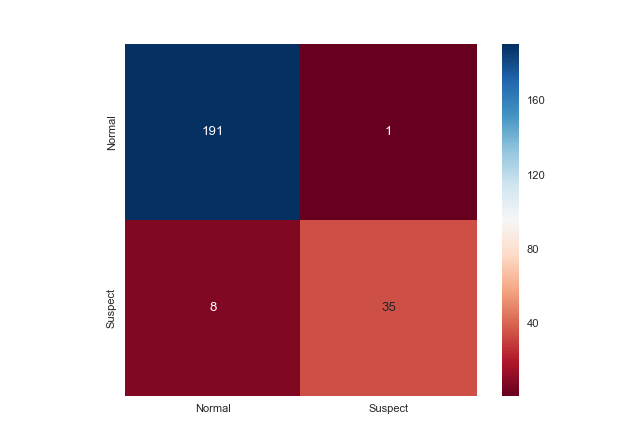

In [15]:
# plot the confusion matrix for the two classes
labels = ['Normal', 'Suspect']

with sns.axes_style('white'):
    plt.figure()
    ax = sns.heatmap(cm, square=True, xticklabels=labels, yticklabels=labels, annot=True, cmap='RdBu', fmt='.0f')    

In [31]:
# Measure feature importance

importances = clf.feature_importances_
features = data.keys()
features_importance = pd.DataFrame(importances, index=features, columns=['Importance'])
sorted_feat_imp = features_importance.sort_values('Importance', axis=0, ascending=False)

print sorted_feat_imp

          Importance
MSTV        0.197126
ASTV        0.126556
ALTV        0.101754
AC          0.081925
UC          0.064901
Min         0.063389
Mean        0.058506
Variance    0.050601
Width       0.049152
LB          0.037937
Mode        0.031697
Median      0.030507
MLTV        0.028291
Max         0.021540
DP          0.019670
FM          0.013724
Nmax        0.009391
DL          0.005212
Tendency    0.004751
Nzeros      0.003370
DS          0.000000


<IPython.core.display.Javascript object>


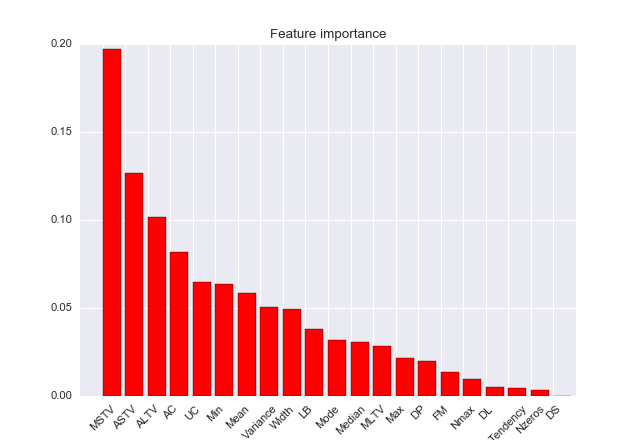

In [18]:
# plot feature importance

plt.figure()
plt.title('Feature importance')
tmp = sorted_feat_imp['Importance'].values.tolist()
plt.bar(range(data.shape[1]), tmp, color='r' )
plt.xticks(range(data.shape[1]), sorted_feat_imp.index, rotation=45, ha='center')
plt.xlim(-1, data.shape[1])
plt.show()

## Add two new features

In [19]:
good_data_23f = good_data

ASTV_x_MSTV = np.multiply(good_data['ASTV'], good_data['MSTV'])
good_data_23f['ASTV_x_MSTV'] = ASTV_x_MSTV

ASTV_div_MSTV = np.divide(good_data['ASTV'], good_data['MSTV'])
good_data_23f['ASTV_div_MSTV'] = ASTV_div_MSTV

good_data_23f.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,ASTV_x_MSTV,ASTV_div_MSTV
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952,1952.000000,1952.00000,1952.000000,1952.000000,...,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,133.570697,0.003219,0.006795,0.004290,0.001537,0,0.000076,47.23002,1.213371,10.629098,...,162.357582,3.767930,0.275102,139.165984,136.351947,139.392418,13.521516,0.355020,51.143596,68.988837
std,9.831284,0.003856,0.037406,0.002914,0.002562,0,0.000392,17.11363,0.730573,18.947843,...,16.752402,2.744724,0.658995,13.186013,13.420595,12.822276,18.554353,0.589056,33.731870,76.229871
min,106.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,12.00000,0.200000,0.000000,...,122.000000,0.000000,0.000000,93.000000,80.000000,101.000000,0.000000,-1.000000,14.600000,3.142857
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0,0.000000,32.00000,0.700000,0.000000,...,151.000000,2.000000,0.000000,129.000000,127.000000,130.000000,2.000000,0.000000,32.000000,21.538462
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0,0.000000,49.00000,1.100000,0.000000,...,160.000000,3.000000,0.000000,140.000000,137.000000,140.000000,6.000000,0.000000,38.500000,41.111111
75%,141.000000,0.006000,0.002000,0.006000,0.002000,0,0.000000,61.00000,1.600000,12.000000,...,172.000000,5.000000,0.000000,148.000000,146.000000,149.000000,18.000000,1.000000,55.800000,85.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0,0.005000,87.00000,7.000000,91.000000,...,238.000000,18.000000,10.000000,180.000000,173.000000,176.000000,136.000000,1.000000,277.200000,435.000000


In [20]:
X_train_23f, X_test_23f, y_train_23f, y_test_23f = train_test_split(good_data_23f, good_labels, test_size=0.20, random_state=0)

# add development set for later analysis of features
X_train_dev_23f, X_test_dev_23f, y_train_dev_23f, y_test_dev_23f = train_test_split(X_train_23f, y_train_23f, test_size = 0.15, random_state=0)

In [21]:
clf_23f = train_forest(X_train_dev_23f, y_train_dev_23f)

y_pred_23f = clf_23f.predict(X_test_dev_23f)

print "F1 score for development set: {}".format(f1_score(y_test_dev_23f, y_pred_23f, average = 'binary', pos_label=1))

Training done in 14.6670000553s
F1 score for development set: 0.820512820513


In [29]:
importances_23f = clf_23f.feature_importances_
features_23f = good_data_23f.keys()
features_importance_23f = pd.DataFrame(importances_23f, index=features_23f, columns=['Importance'])
sorted_feat_imp_23f = features_importance_23f.sort_values('Importance', axis=0, ascending=False)
print sorted_feat_imp_23f

               Importance
ASTV_div_MSTV    0.172080
MSTV             0.120701
ASTV_x_MSTV      0.115248
ALTV             0.079210
ASTV             0.073957
AC               0.058440
UC               0.049846
Mean             0.044996
Min              0.037645
Median           0.033939
Width            0.033053
LB               0.029445
Variance         0.028504
Mode             0.026134
MLTV             0.023044
Max              0.021022
DP               0.019812
Nmax             0.012390
FM               0.011434
Tendency         0.003201
Nzeros           0.003162
DL               0.002739
DS               0.000000


In [24]:
healthy_data = data.loc[fs_labels == -1, :]
reduced_h_data = healthy_data[sorted_feat_imp.index[0:5]]

suspect_data = data.loc[fs_labels == 1, :]
reduced_s_data = suspect_data[sorted_feat_imp.index[0:5]]

<IPython.core.display.Javascript object>


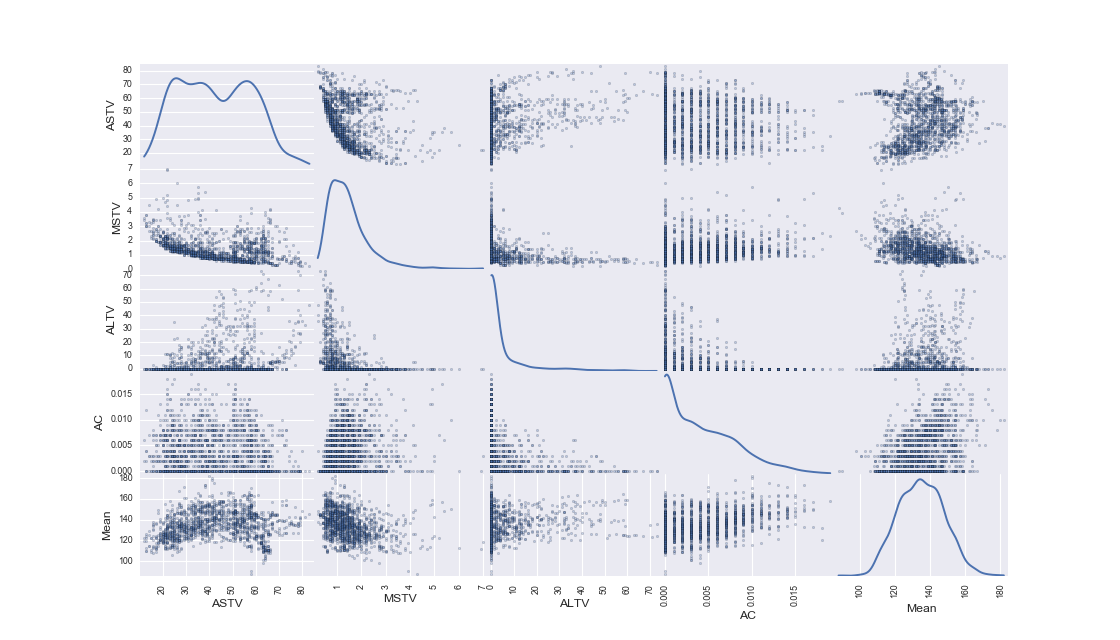

In [25]:
pd.scatter_matrix(reduced_h_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

<IPython.core.display.Javascript object>


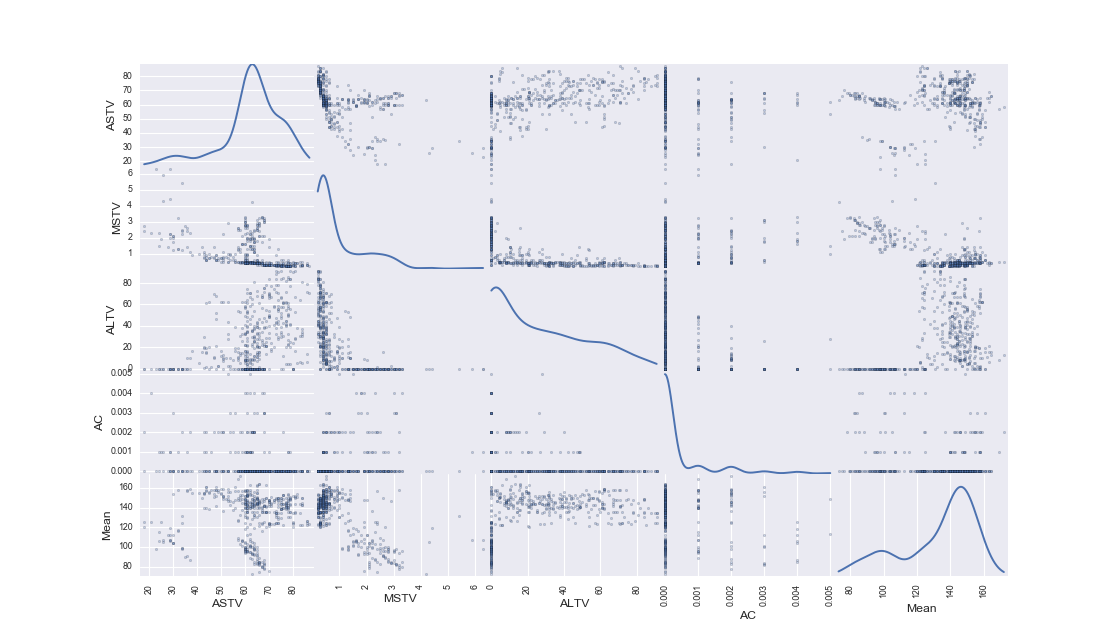

In [26]:
pd.scatter_matrix(reduced_s_data, alpha=0.3, figsize = (14,8), diagonal = 'kde');

<IPython.core.display.Javascript object>


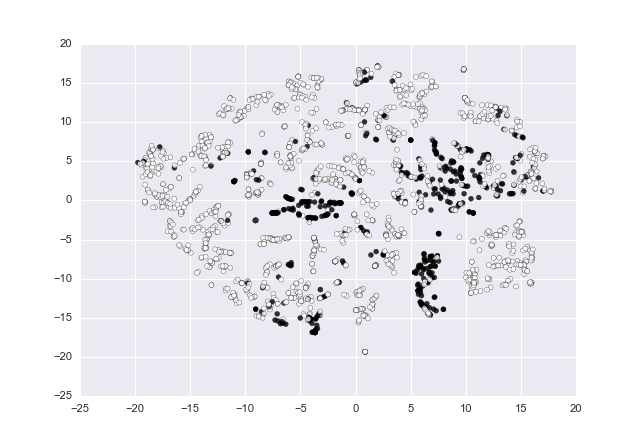

In [48]:
from sklearn.manifold import TSNE

data_tsne = TSNE(n_components = 2).fit_transform(data)

x_min, x_max = data_tsne[:,0].min() - 1, data_tsne[:,1].max() + 1
y_min, y_max = data_tsne[:,0].min() - 1, data_tsne[:,1].max() + 1

# create the meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

plt.figure()
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=fs_labels, alpha = 0.8)
plt.show()

In [49]:
data_tsne = TSNE(n_components = 2).fit_transform(X_train_dev_23f)

x_min, x_max = data_tsne[:,0].min() - 1, data_tsne[:,1].max() + 1
y_min, y_max = data_tsne[:,0].min() - 1, data_tsne[:,1].max() + 1

# create the meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

diff = y_pred_23f - y_test_dev_23f 
labels = y_pred_23f + diff


In [65]:
from sklearn.preprocessing import MinMaxScaler

s_labels = MinMaxScaler().fit_transform(labels)

scld_labels = pd.Series(s_labels, index=labels.index)

C:\Users\Ludovica\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ludovica\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Ludovica\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [64]:
plt.figure()
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=scld_labels, alpha = 0.8)
plt.show()

<IPython.core.display.Javascript object>

ValueError: to_rgba: Invalid rgba arg "0.333333333333"
to_rgb: Invalid rgb arg "0.333333333333"
cannot convert argument to rgb sequence